In [1]:
%matplotlib inline
]]]]]]]]]

/home/ehrhardt98/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ehrhardt98/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ehrhardt98/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ehrhardt98/.local/lib/python3.6/site-packages/tensorflow/python/framework

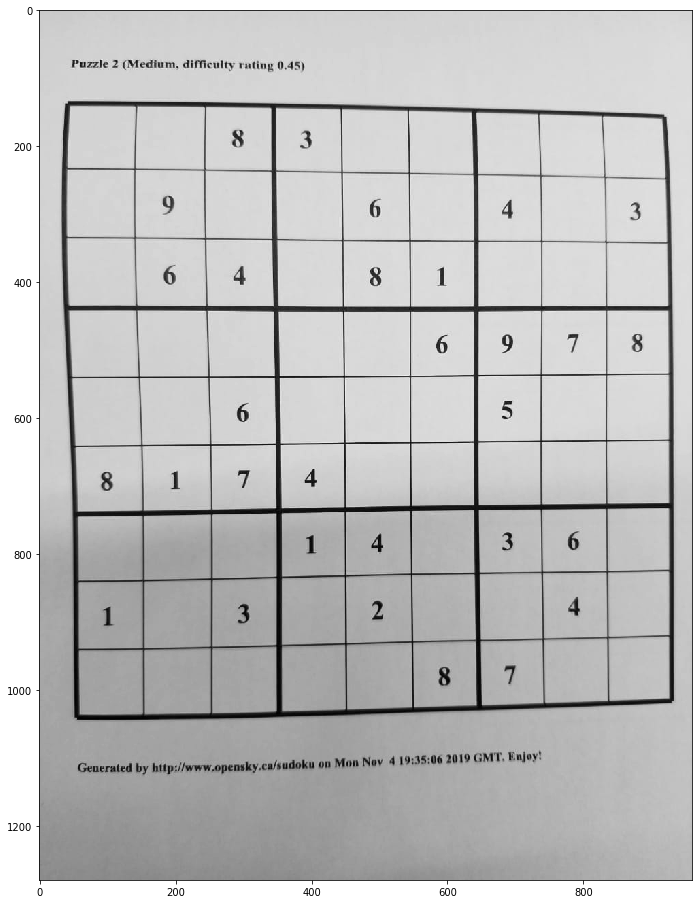

In [2]:
img_sudoku = cv2.cvtColor(cv2.imread('jorgeavbe-2.png'), cv2.COLOR_BGR2GRAY) # carrega a imagem escolhida
plt.figure(figsize=(16,16))
plt.imshow(img_sudoku, cmap='gray', vmin=0, vmax=255)

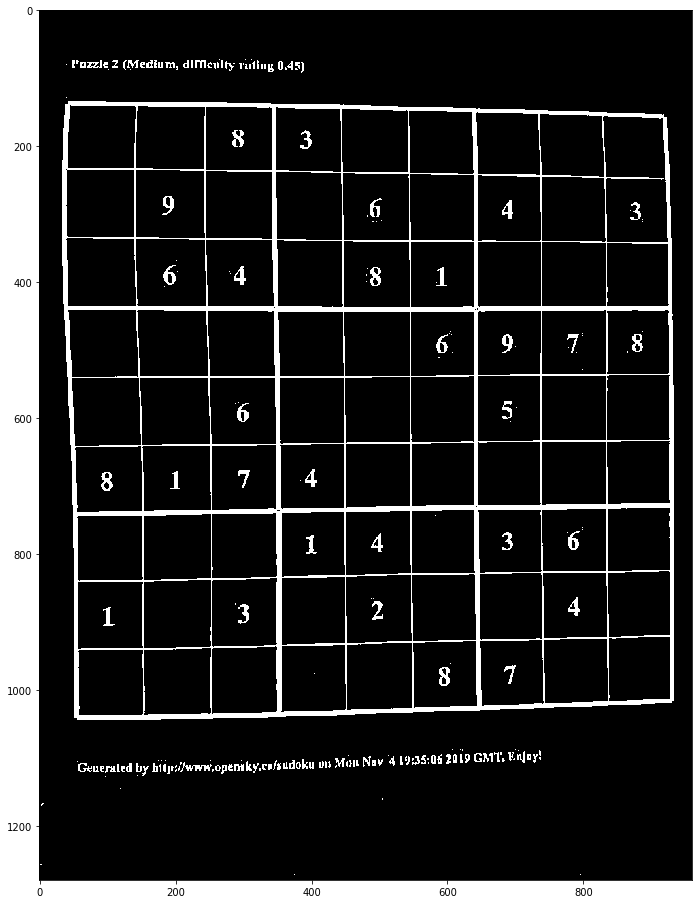

In [3]:
sudoku_test = cv2.adaptiveThreshold(img_sudoku, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5) #transformar a imagem em binária com threshold adaptativo
plt.figure(figsize=(16,16))
plt.imshow(sudoku_test, cmap='gray', vmin=0, vmax=255)

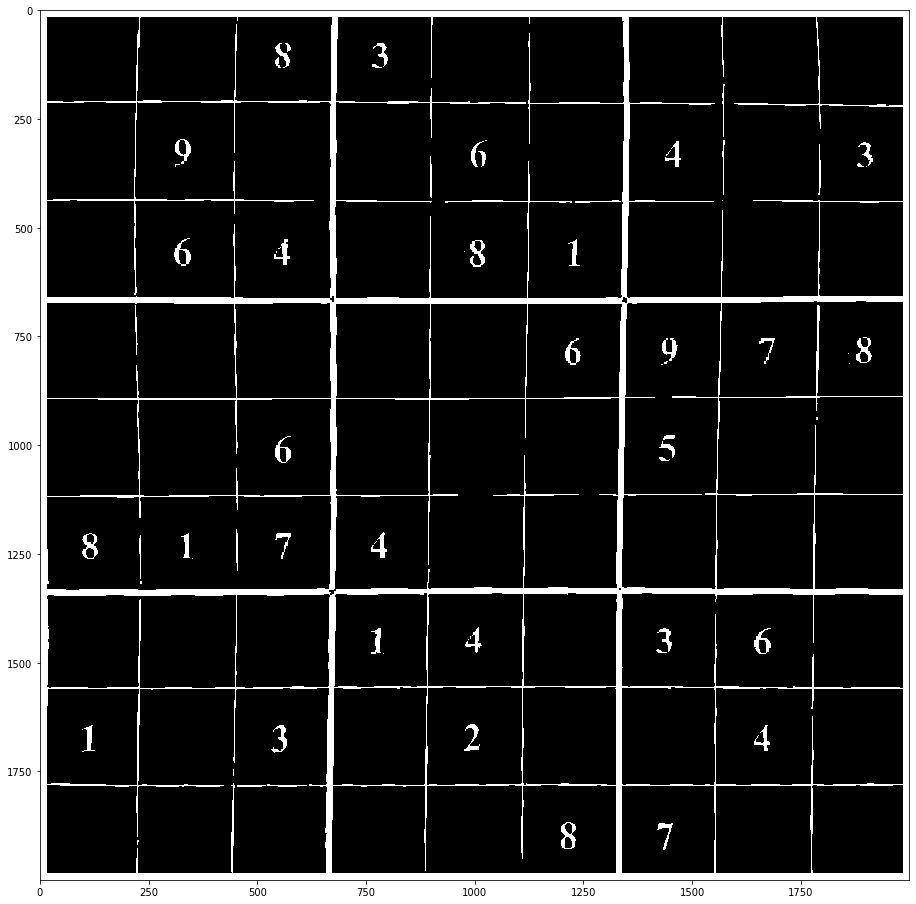

In [4]:
# mudança de perspectiva para que o grid do sudoku fique reto e ocupe a imagem inteira.

w, h = sudoku_test.shape

contours, hierarchy = cv2.findContours(sudoku_test, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if len(contours) != 0:
    c2 = max(contours, key = cv2.contourArea)

corners = []
i = 0
while len(corners) != 4:
    corners = cv2.approxPolyDP(c2, i, True)
    i += 1

for corner in corners:
    if corner[0][0] < w/2:
        if corner[0][1] < h/2:
            ul = corner[0] # upper left
        else:
            ll = corner[0] # lower left
    else:
        if corner[0][1] < h/2:
            ur = corner[0] # upper right
        else:
            lr = corner[0] # lower right

cols, rows = 2000, 2000 # redimensionar para o plot não ficar achatado

original = np.float32([ul, ll, ur, lr])
perspec = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])


M = cv2.getPerspectiveTransform(original, perspec)
grid_crop = cv2.warpPerspective(sudoku_test, M, (cols, rows))

grid_crop = cv2.rectangle(grid_crop, (1,1), (cols-1, rows-1), (255,255,255), thickness=30)

grid_crop = morphology.remove_small_objects(grid_crop, min_size=9000)

plt.figure(figsize=(16, 16))
plt.imshow(grid_crop, cmap='gray')

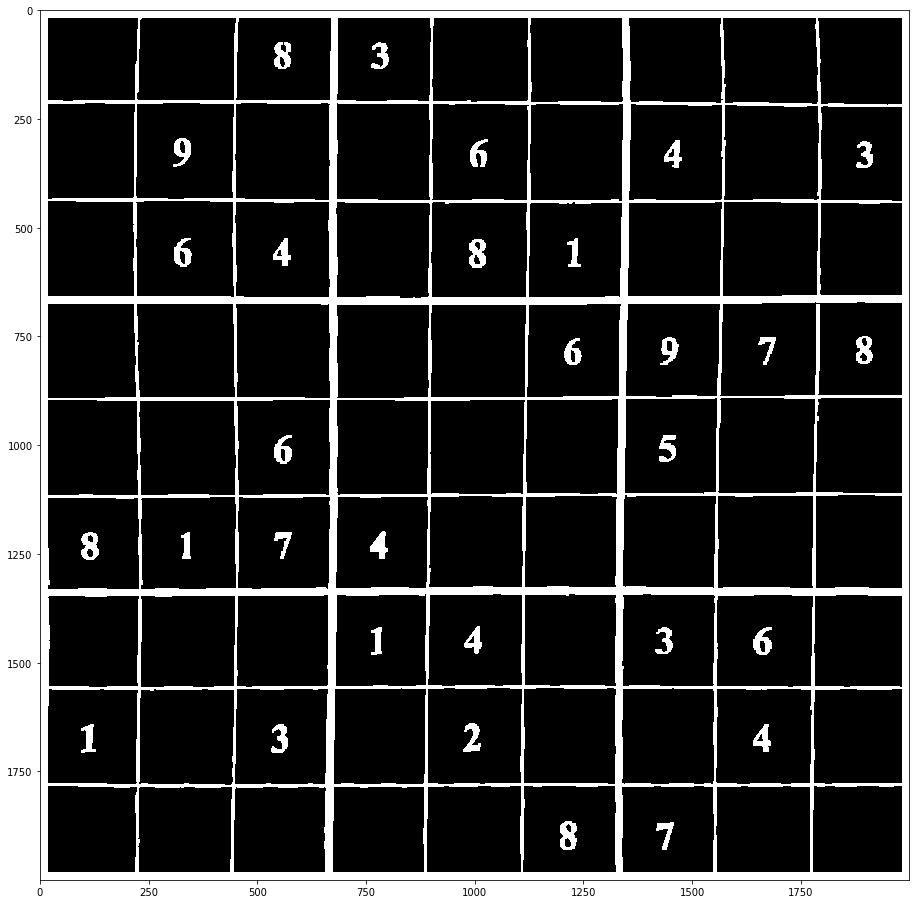

In [5]:
img = morphology.dilation(grid_crop, morphology.square(5)) > 0 # dilation para deixas as linhas mais largas, para que os quadrados (props) fiquem bem definidos
img1 = morphology.remove_small_objects(img, min_size=100)
img1 = morphology.remove_small_holes(img1, 110, connectivity=2)
img1 = morphology.remove_small_holes(img1, 110)
plt.figure(figsize=(16,16))
plt.imshow(img1, cmap="gray")

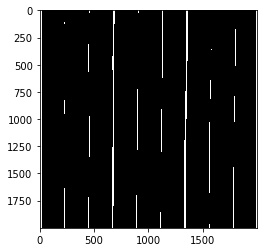

In [6]:
verticals = morphology.erosion(img1, morphology.rectangle(130, 1)) # separar as linhas verticais
# plt.figure(figsize=(16,16))
plt.imshow(verticals, cmap="gray")

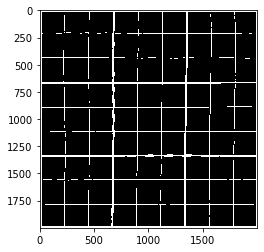

In [7]:
# reconstruction das verticais com o grid do sudoku para obter somente o grid
img2 = morphology.reconstruction(verticals, img1)
# plt.figure(figsize=(16,16))
plt.imshow(img2, cmap="gray")

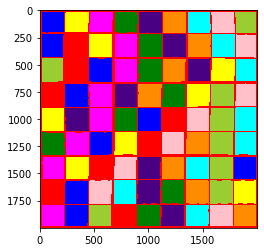

In [8]:
from skimage.color import label2rgb
img3 = morphology.dilation(img2, morphology.square(5)) > 0

img = ~img3
# plt.figure(figsize=(16,16))
plt.imshow(label2rgb(morphology.label(img))) # criação dos props

81


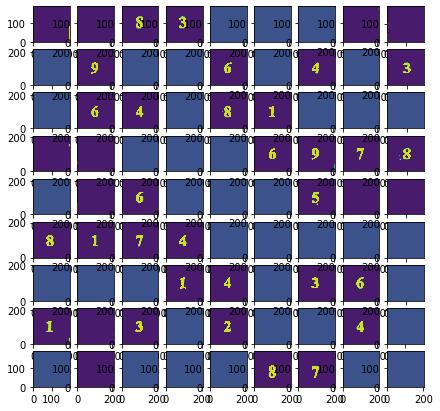

In [9]:
from skimage.measure import regionprops

props = regionprops(morphology.label(img))

fig, axs = plt.subplots(9,9, figsize=(7, 7)) # setup do plot para plotar em 9x9
axs = axs.ravel()

prop_list = []
crop_list = []

soma = 0
for i in props:
    soma += i.area

soma /= len(props)

props = [i for i in props if i.area > 0.50 * soma] # selecionar os props desejados (aqueles com área desejada).

print(len(props))

for i in range(81):
    prop_list.append(props[i].bbox)

chunks = [prop_list[x:x+9] for x in range(0, len(prop_list), 9)] # percorrer a lista de props de 9 em 9, adicionando cada linha do sudoku em uma lista separada
for i in chunks:
    i.sort(key = operator.itemgetter(1)) # ordenação da lista pelo segundo elemento (posição da primeira coluna do prop), pois os props vêm ordenados em linhas, mas a ordem das linhas pode estar errada.
chunks = [item for sublist in chunks for item in sublist] # reagrupar as listas de props em uma só

tem_ou_nao = []
tiles = []
hist_list = []

a = 0
for i in chunks: # criar os respectivos crops de cada prop, já plotando cada um em sua respectiva posição
    crop = grid_crop[i[0]:i[2], i[1]:i[3]]
    tiles.append(crop)
    soma = np.sum(grid_crop[i[0]:i[2], i[1]:i[3]])
    tem_ou_nao.append(soma/((i[2]-i[0]) * (i[3]-i[1])))
    axs[a].contourf(crop[::-1])
    a+=1

In [10]:
media = np.sum(tem_ou_nao) / len(tem_ou_nao)

print(media)

tem_ou_nao_bool = tem_ou_nao > media # filtrar os tiles que têm números para impedir predicts desnecessários e errados.
tem_ou_nao_bool

1.8169664300292927


array([False, False,  True,  True, False, False, False, False, False,
       False,  True, False, False,  True, False,  True, False,  True,
       False,  True,  True, False,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
       False, False,  True, False, False, False,  True, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
        True, False,  True, False,  True, False, False,  True, False,
       False, False, False, False, False,  True,  True, False, False])

In [11]:
modelo = load_model("modelo.h5")# carrega o modelo previamente treinado

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


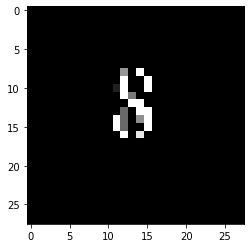

8


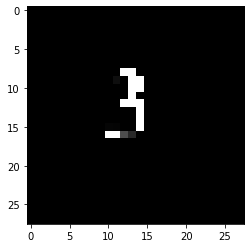

3


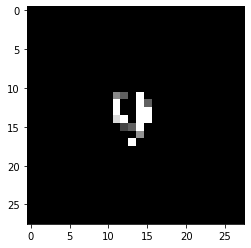

9


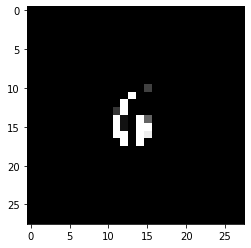

6


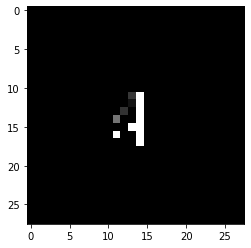

4


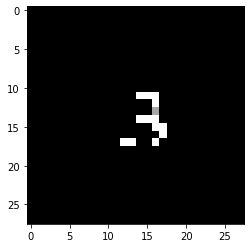

3


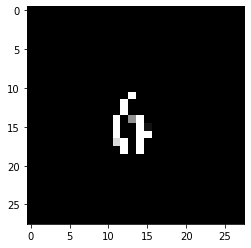

6


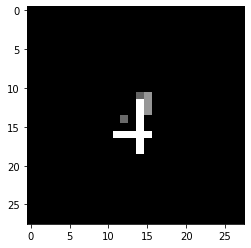

4


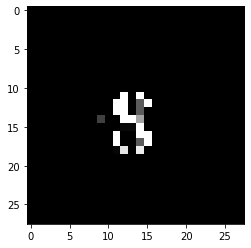

8


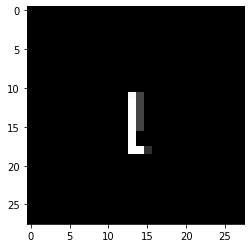

1


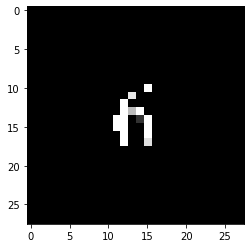

6


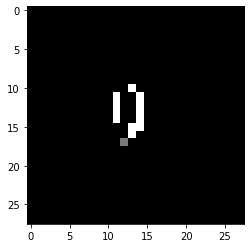

9


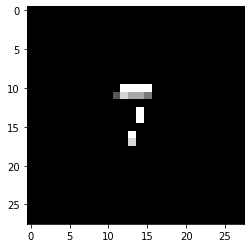

7


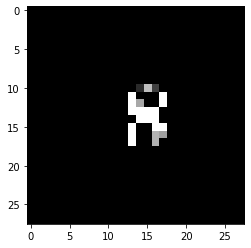

8


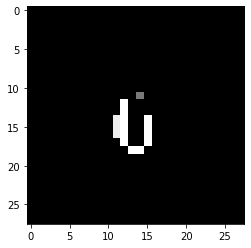

6


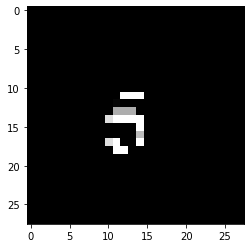

5


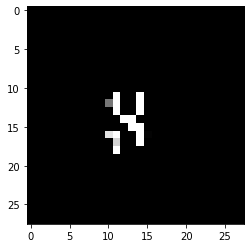

8


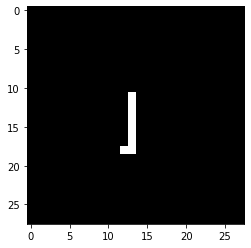

1


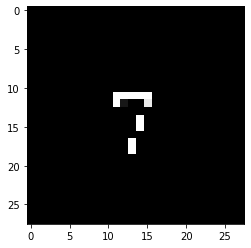

7


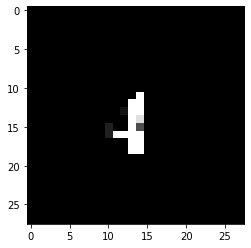

4


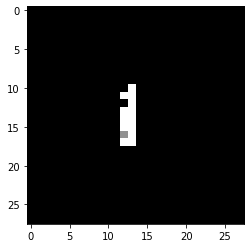

1


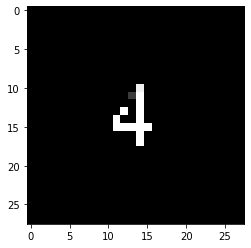

4


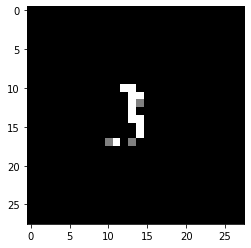

3


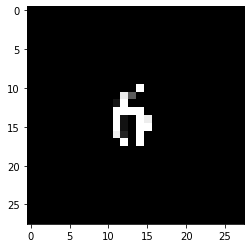

6


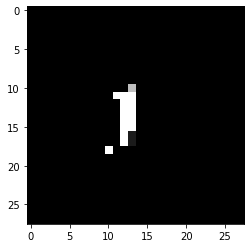

1


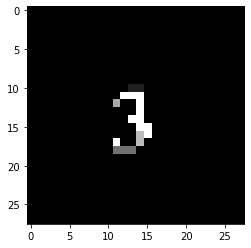

3


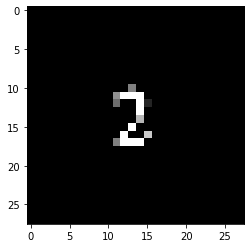

2


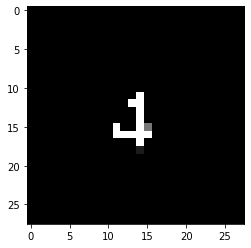

4


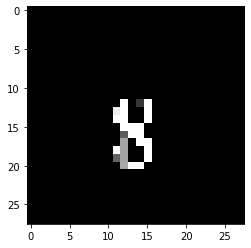

8


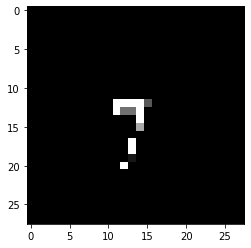

7


In [12]:
prediction_list = []
for i in range(len(tem_ou_nao_bool)): # realiza o predict para cada tile que tem número
    if tem_ou_nao_bool[i]:
        tile = cv2.resize(tiles[i], (28, 28))
        plt.imshow(tile, cmap="gray")
        plt.show()
        tile = tile.reshape((1, 28, 28, 1))
        prediction = np.argmax(modelo.predict(tile))
        prediction_list.append(prediction)
        print(prediction)
    else:
        prediction_list.append(0)
        continue

In [13]:
# funcoes para resolver e plotar o tabuleiro retiradas de uma thread do stack overflow

def solve(bo):
    find = find_empty(bo)
    if not find:
        return bo
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False


def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True


def print_board(bo):
    print("")
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("-------+--------+-------")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                if bo[i][j] == 0:
                    print("-")
                else:
                    print(bo[i][j])
            else:
                if bo[i][j] == 0:
                    print("-" + " ", end="")
                else: 
                    print(str(bo[i][j]) + " ", end="")
    print("")


def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)

    return None

In [14]:
prediction_list

[0,
 0,
 8,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 6,
 0,
 4,
 0,
 3,
 0,
 6,
 4,
 0,
 8,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 9,
 7,
 8,
 0,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 8,
 1,
 7,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 3,
 6,
 0,
 1,
 0,
 3,
 0,
 2,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 7,
 0,
 0]

In [15]:
board = list(np.array(prediction_list).reshape(9,9))
print_board(board) # print do tabuleiro, substituindo 0 por .


- - 8  | 3 - -  | - - -
- 9 -  | - 6 -  | 4 - 3
- 6 4  | - 8 1  | - - -
-------+--------+-------
- - -  | - - 6  | 9 7 8
- - 6  | - - -  | 5 - -
8 1 7  | 4 - -  | - - -
-------+--------+-------
- - -  | 1 4 -  | 3 6 -
1 - 3  | - 2 -  | - 4 -
- - -  | - - 8  | 7 - -



In [17]:
board_solve = board.copy()
solve(board_solve)
print_board(board_solve)


2 7 8  | 3 5 4  | 1 9 6
5 9 1  | 7 6 2  | 4 8 3
3 6 4  | 9 8 1  | 2 5 7
-------+--------+-------
4 3 5  | 2 1 6  | 9 7 8
9 2 6  | 8 7 3  | 5 1 4
8 1 7  | 4 9 5  | 6 3 2
-------+--------+-------
7 8 2  | 1 4 9  | 3 6 5
1 5 3  | 6 2 7  | 8 4 9
6 4 9  | 5 3 8  | 7 2 1



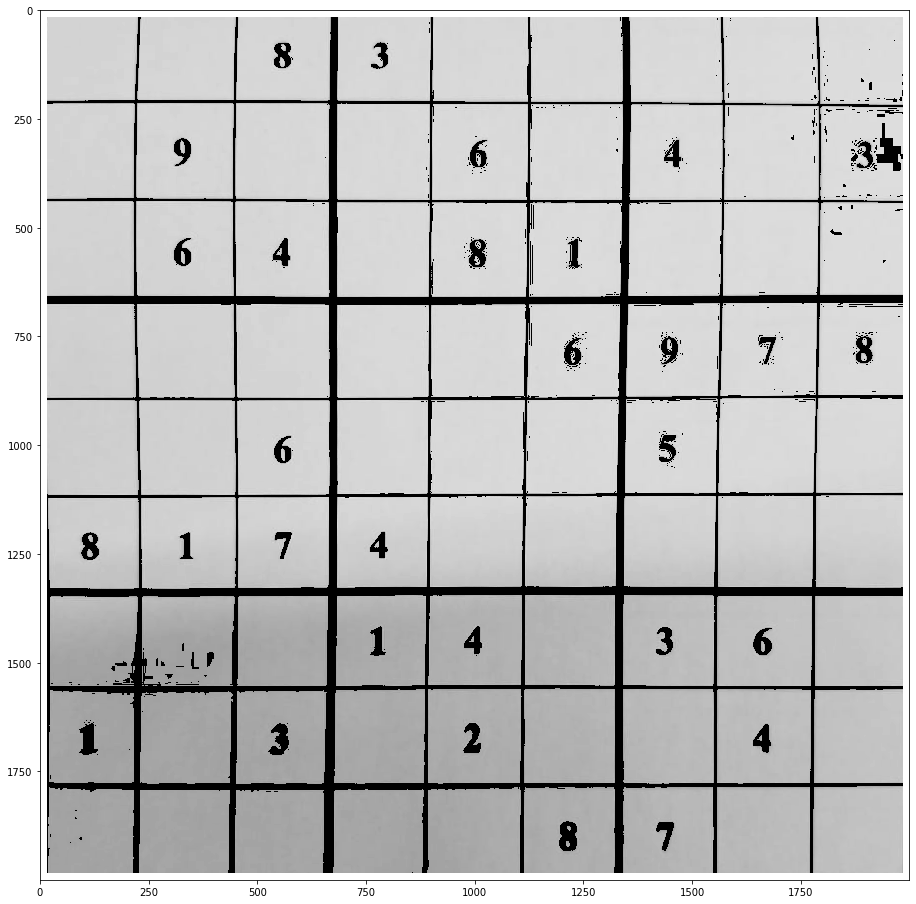

In [18]:
# refaz a mudanca de perspectiva, agora com a imagem antes do threshold
# em alguns casos, a mudanca de perspectiva pode gerar pequenos danos na imagem

w, h = sudoku_test.shape

contours, hierarchy = cv2.findContours(sudoku_test, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if len(contours) != 0:
    c2 = max(contours, key = cv2.contourArea)

corners = []
i = 0
while len(corners) != 4:
    corners = cv2.approxPolyDP(c2, i, True)
    i += 1

for corner in corners:
    if corner[0][0] < w/2:
        if corner[0][1] < h/2:
            ul = corner[0] # upper left
        else:
            ll = corner[0] # lower left
    else:
        if corner[0][1] < h/2:
            ur = corner[0] # upper right
        else:
            lr = corner[0] # lower right

cols, rows = 2000, 2000 # redimensionar para o plot não ficar achatado

original = np.float32([ul, ll, ur, lr])
perspec = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])


M = cv2.getPerspectiveTransform(original, perspec)
grid_crop = cv2.warpPerspective(img_sudoku, M, (cols, rows))

grid_crop = cv2.rectangle(grid_crop, (1,1), (cols-1, rows-1), (255,255,255), thickness=30)

grid_crop = morphology.remove_small_objects(grid_crop, min_size=9000)

plt.figure(figsize=(16, 16))
plt.imshow(grid_crop, cmap='gray')

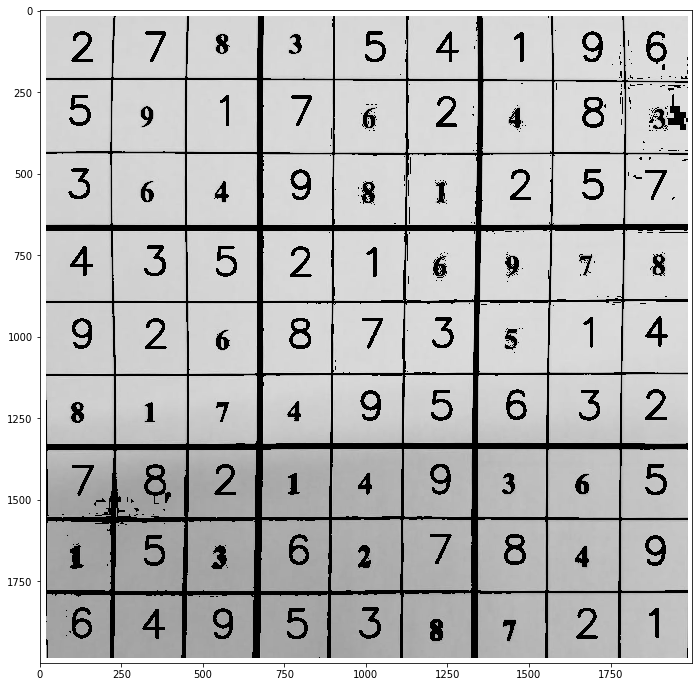

In [19]:
board = list(np.array(prediction_list).reshape(9,9)) # refaz o board, pois a funcao solve() resolve o board criado acima

# codigo para printar os resultados sobre a imagem original

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale  = 4
fontColor = (0,0,0)
lineType = 2
thickness = 10

img_solve = (grid_crop.astype("uint8"))

img_solve = cv2.cvtColor(img_solve, cv2.COLOR_BGR2RGB)

for i in range(9):
    for j in range(9):
        if board[i][j] == 0:
            min_row, min_col, max_row, max_col = chunks[i*9 + j]
            row_wr = int(min_row + 2000/15)
            col_wr = int(max_col - 2000/15)
            cv2.putText(img_solve, str(board_solve[i][j]), (col_wr, row_wr), font, fontScale, fontColor, thickness, lineType)

        
plt.figure(figsize=(12,12))
plt.imshow(img_solve)
plt.show()